In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! ls

drive  gdrive  sample_data


In [2]:
%cd drive/My Drive/Academic projects/project_folder/

/content/drive/My Drive/Academic projects/project_folder


In [3]:
! git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [8]:
cd /content/drive/My Drive/Academic projects/project_folder/Mask_RCNN/

/content/drive/My Drive/Academic projects/project_folder/Mask_RCNN


In [9]:
!pip3 install -r requirements.txt

In [10]:
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/__init__.py to __init_

In [11]:
%tensorflow_version 1.15

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [12]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = "/content/drive/My Drive/Academic projects/project_folder/Mask_RCNN"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


In [13]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Loading weights

In [14]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


# The classes of the COCO dataset

In [15]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [27]:
# Load a random image from the images folder
def detection(file_names):
  output_file_name = file_names.split(".")[0]
  image = skimage.io.imread(file_names)
  # Run detection
  results = model.detect([image], verbose=1)

  # Visualize results
  r = results[0]
  masked_image = visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              class_names, r['scores'])
  return masked_image, results, image

# Loading image

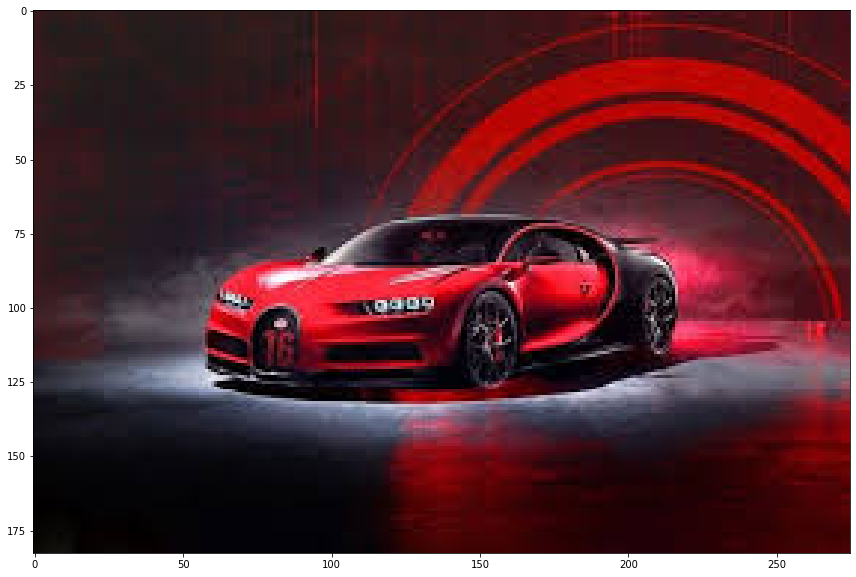

In [61]:
# Load a random image from the images folder
image = skimage.io.imread('download.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

# Masking on single car image

Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


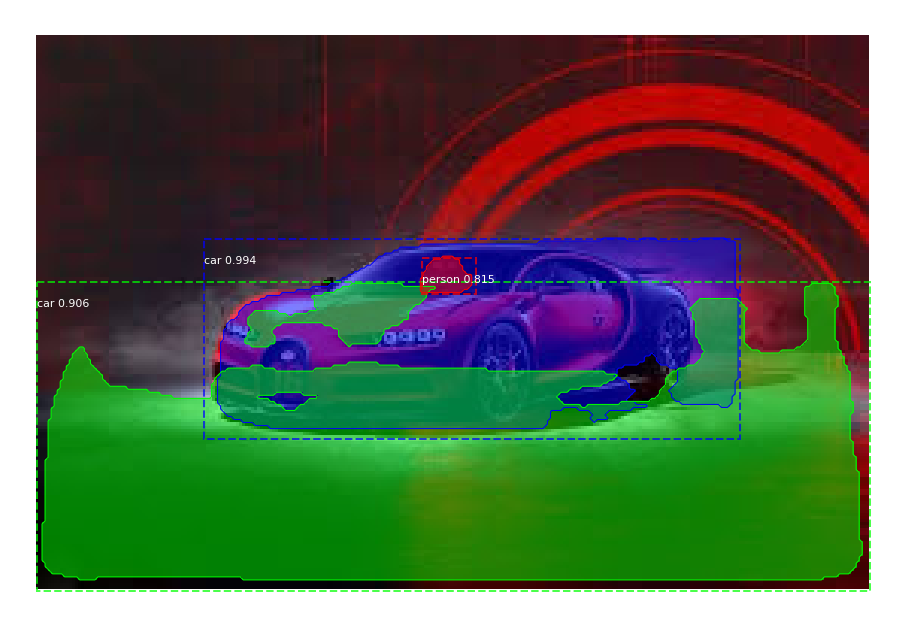

In [28]:
file_names = 'download.jpg'
masked_image, results, image = detection(file_names)

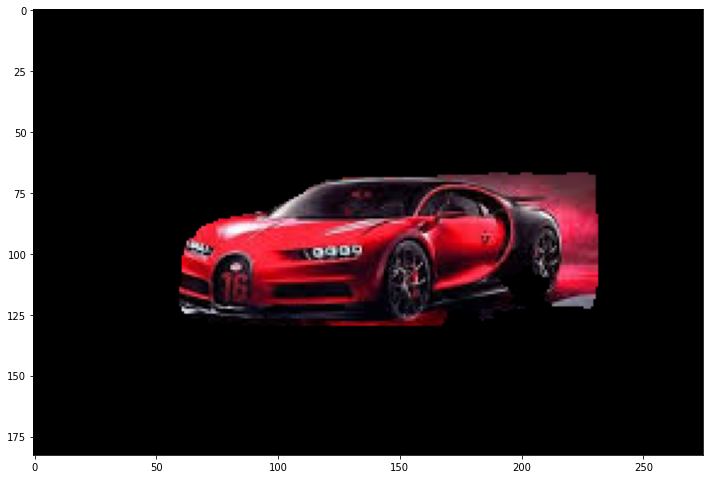

In [33]:
if results[0]["class_ids"][0] == 3:
  output_image = np.array([0]*(image.shape[0]* image.shape[1]*3)).reshape(image.shape)
  output_image[np.where(results[0]["masks"][:,:,0] == True)] = image[np.where(results[0]["masks"][:,:,0] == True)]

  fig, ax = plt.subplots(figsize=(12, 12))
  ax.imshow(output_image)
  plt.show()

# Single person image

Processing 1 images
image                    shape: (1280, 960, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


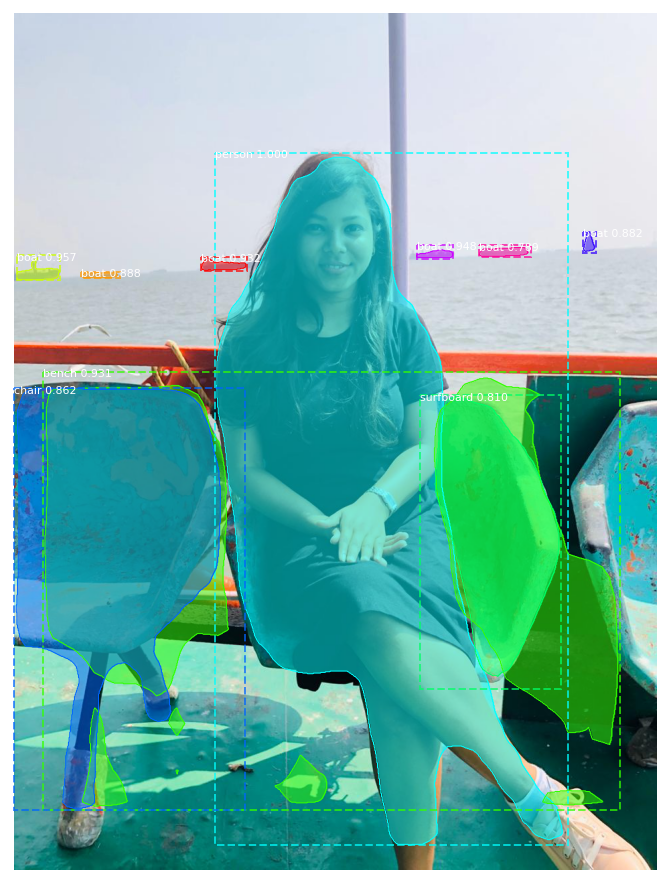

In [34]:
file_names = 'me.jpg'
masked_image, results, image = detection(file_names)

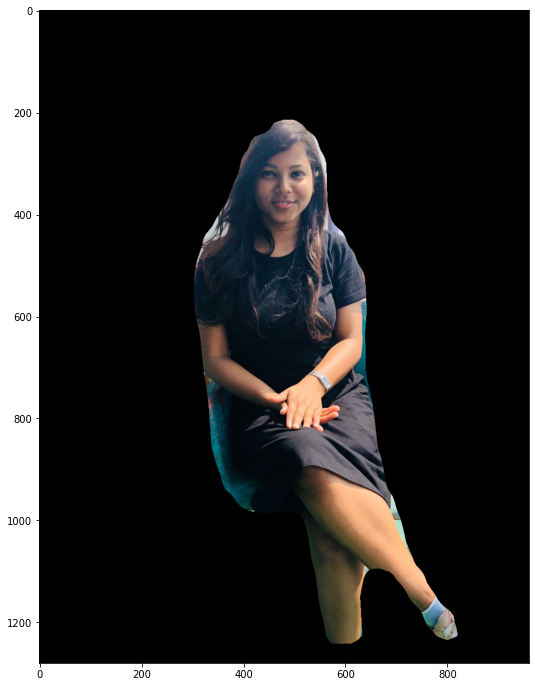

In [50]:
# if results[0]["class_ids"][0] == 1:
output_image = np.array([0]*(image.shape[0]* image.shape[1]*3)).reshape(image.shape)
output_image[np.where(results[0]["masks"][:,:,0] == True)] = image[np.where(results[0]["masks"][:,:,0] == True)]

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(output_image)
plt.show()

# Masking on multiple cars

Processing 1 images
image                    shape: (156, 323, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


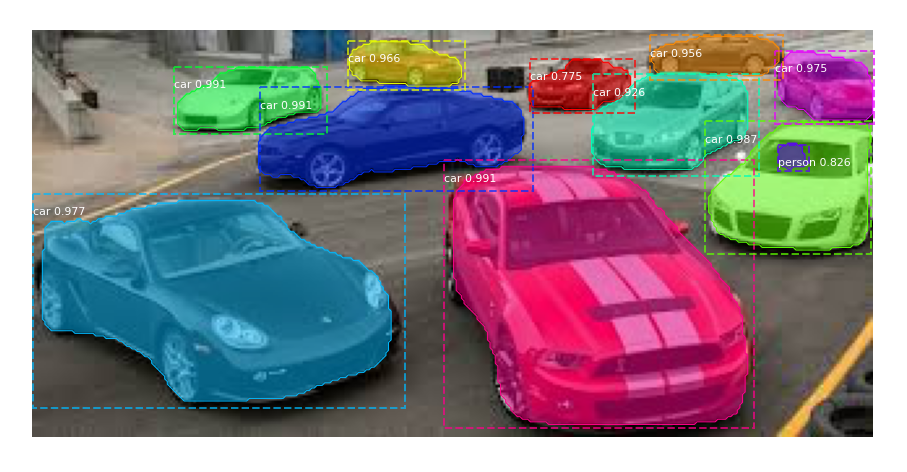

In [58]:
file_names = 'images.jpg'
masked_image, results, image = detection(file_names)

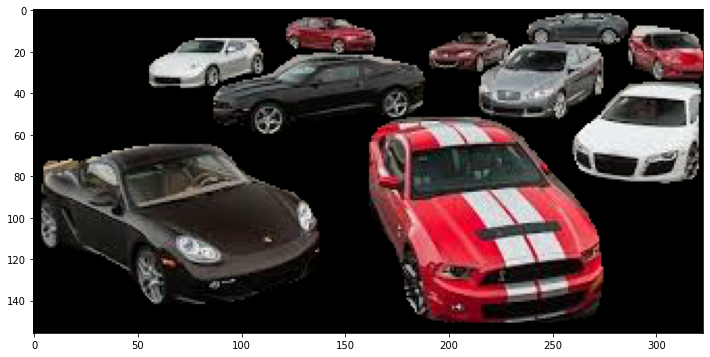

In [59]:
output_image = np.array([0]*(image.shape[0]* image.shape[1]*3)).reshape(image.shape)

for i in range(len(results[0]["class_ids"])):
  if results[0]["class_ids"][i]==3:
    output_image[np.where(results[0]["masks"][:,:,i] == True)] = image[np.where(results[0]["masks"][:,:,i] == True)]

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(output_image)
plt.show()

# Masking on Group Picture

Processing 1 images
image                    shape: (3456, 4608, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 4608.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


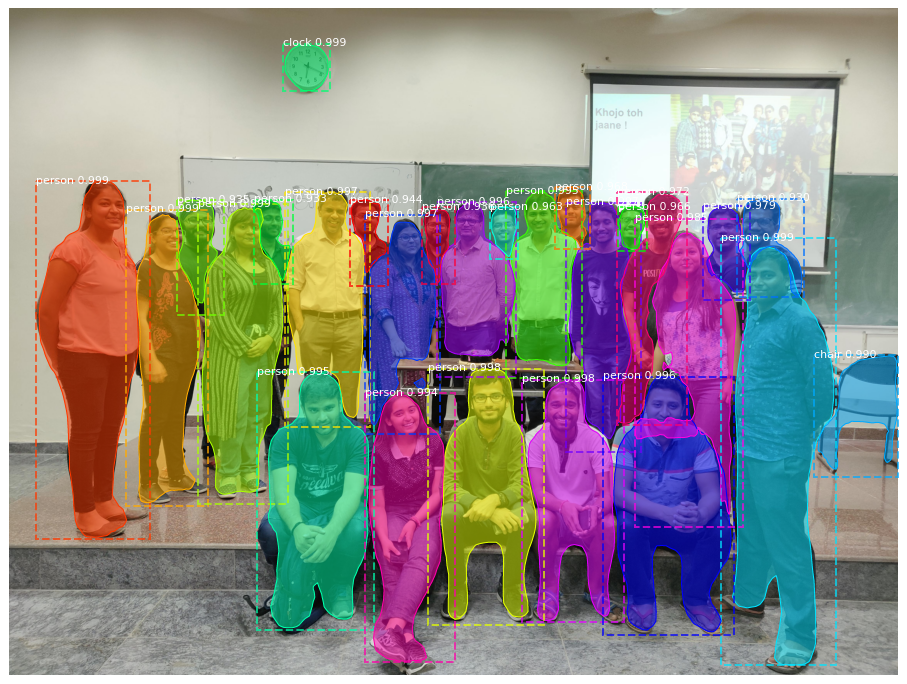

In [62]:
file_names = 'BDA.jpg'
masked_image, results, image = detection(file_names)

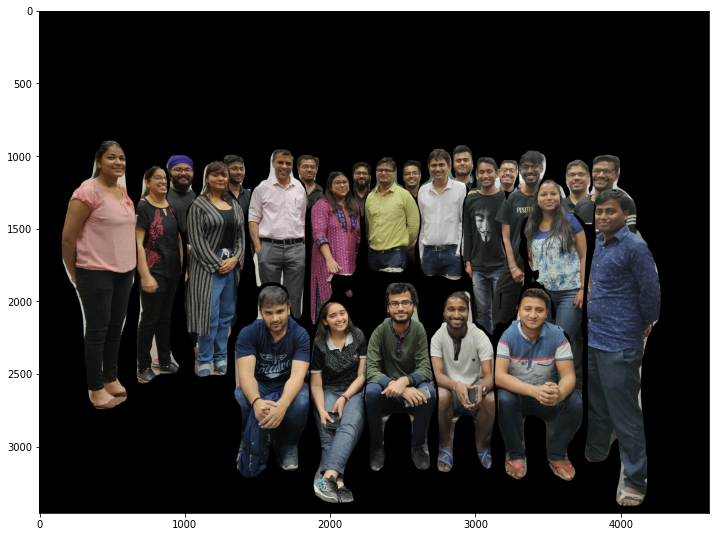

In [65]:
output_image = np.array([0]*(image.shape[0]* image.shape[1]*3)).reshape(image.shape)

for i in range(len(results[0]["class_ids"])):
  if results[0]["class_ids"][i]==1:
    output_image[np.where(results[0]["masks"][:,:,i] == True)] = image[np.where(results[0]["masks"][:,:,i] == True)]

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(output_image)
plt.show()